In [7]:
 !pip install pysal h3

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━

In [8]:
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import tobler
from sklearn.neighbors import RadiusNeighborsRegressor

# --- 1. Define Unit and Load Data ---
myEstate = "80 Rugg Rd, Allston, MA 02134"
unit_bedrooms = 2.0
unit_property_type = 'Entire rental unit'

linkBostonBorder="https://github.com/aditipabal/AIRBNB-RENTAL/raw/main/GISDATA.TOWNSSURVEY_POLYM.zip"
boston=gpd.read_file(linkBostonBorder)
boston_crs = boston.crs # Store CRS for re-projection

linkBostonAIrbnb="https://github.com/aditipabal/AIRBNB-RENTAL/raw/main/listings.csv"
airbnb_all=pd.read_csv(linkBostonAIrbnb)

# --- 2. Clean and Filter AirBnB Data ---
keep = ['id','price','bedrooms','property_type','latitude','longitude']
airbnb = airbnb_all[keep].copy()

# Clean price column
airbnb['price'] = airbnb.price.str.replace(r'\$|\,', '', regex=True).astype(float)
airbnb.dropna(inplace=True)

# Filter for similar units
conditionText = f"bedrooms=={unit_bedrooms} & property_type=='{unit_property_type}'"
airbnb_source = airbnb.query(conditionText).copy()

# Remove duplicate listings based on location
key_columns = ['latitude', 'longitude']
airbnb_source_unique = airbnb_source.drop_duplicates(subset=key_columns)

# Convert to GeoDataFrame and reproject
airbnb_source_gdf = gpd.GeoDataFrame(
    airbnb_source_unique,
    geometry=gpd.points_from_xy(airbnb_source_unique.longitude, airbnb_source_unique.latitude),
    crs='EPSG:4326'
).to_crs(boston_crs)

# --- 3. Create Target Grid (H3 Hexagon Centroids) ---
# Create H3 grid for interpolation targets
boston_grid10 = tobler.util.h3fy(boston.to_crs(4326), resolution=10).to_crs(boston_crs)
boston_target_locations = boston_grid10.centroid.get_coordinates()

# Coordinates and Prices for known units
airbnb_source_locations = airbnb_source_gdf.get_coordinates()
airbnb_source_prices = airbnb_source_gdf.price

# --- 4. Perform Spatial Interpolation (Radius-based IDW) ---
# Use RadiusNeighborsRegressor (1000m radius, distance-weighted)
interpolation_radius = RadiusNeighborsRegressor(
    radius=1000, weights="distance"
)
interpolation_radius.fit(
    airbnb_source_locations, airbnb_source_prices
)

# Predict prices for all hex centroids in the grid
boston_grid10["radius_1000"] = interpolation_radius.predict(boston_target_locations)

# --- 5. Geocode My Unit and Extract Price ---
geolocator = Nominatim(user_agent="theGeocoder")
myEstate_Address = geolocator.geocode(myEstate)

# Create GeoDataFrame for my unit
myEstats_gdf4326 = gpd.GeoDataFrame(
    {'address': [myEstate_Address.address]},
    geometry=[Point(myEstate_Address.longitude, myEstate_Address.latitude)],
    crs="EPSG:4326"
)
myEstats_gdf = myEstats_gdf4326.to_crs(boston_crs)

# Spatial Join to find which hexagon my unit falls into
my_unit_price_info = myEstats_gdf.sjoin(
    boston_grid10[['radius_1000', 'geometry']],
    how="left",
    predicate="within"
)

# Final Suggested Price
suggested_price = my_unit_price_info['radius_1000'].iloc[0]

# --- 6. Prepare Final Output Data for R Flexdashboard ---
# Export the interpolated grid and my unit's location
boston_grid10[['radius_1000', 'geometry']].to_file(
    "boston_price_grid.geojson", driver="GeoJSON"
)
myEstats_gdf.to_file(
    "my_unit_location.geojson", driver="GeoJSON"
)

# Print the result
print(f"--- Final Estimated Rental Price ---")
print(f"Location: {myEstate_Address.address}")
print(f"Price (IDW, 1000m Radius): ${suggested_price:,.2f} per night")
print(f"")
print(f"Data for R Flexdashboard exported to: 'boston_price_grid.geojson' and 'my_unit_location.geojson'")

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_regression.py:508: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


--- Final Estimated Rental Price ---
Location: 80, Rugg Road, Union Square, Allston, Boston, Suffolk County, Massachusetts, 02134, United States of America
Price (IDW, 1000m Radius): $408.58 per night

Data for R Flexdashboard exported to: 'boston_price_grid.geojson' and 'my_unit_location.geojson'


In [10]:
# Final Suggested Price
suggested_price = my_unit_price_info['radius_1000'].iloc[0]

# --- Print the result ---
print(f"Price (IDW, 1000m Radius): ${suggested_price:,.2f} per night")

Price (IDW, 1000m Radius): $408.58 per night


<Axes: >

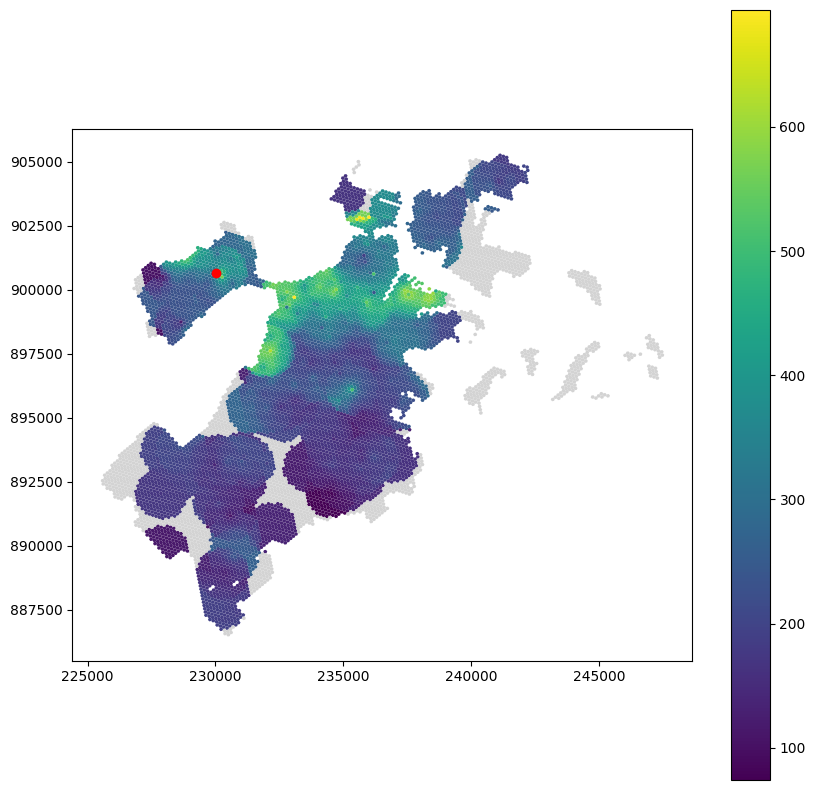

In [9]:
base=boston_grid10.plot("radius_1000", legend=True, missing_kwds={'color': 'lightgrey'},figsize=(10,10))
myEstats_gdf.plot(ax=base,color='red')